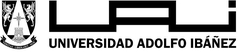

#**Laboratorio 01:** Clasificación lineal multiclase y redes neuronales convolucionales

**Fecha de Entrega:** 23 de abril de 2021

# Integrante(s): 
(*3 alumnos como máximo*)


1.   Alumno 01
2.   Alumno 02 (Opcional)
3.   Alumno 03 (Opcional)


# 1. Introducción

##1.1 Descripción del problema

Dada la base de datos vista en clases de imágenes de perros y gatos, se desea comparar el rendimiento de un clasificador lineal multiclase con respecto a un clasificador basado en redes neuronales profunda del tipo convolucional multiclase. 

Para realizar este trabajo, debe implementar ambos clasificadores utilizando el código visto en clases.

El documento de laboratorio debe contener las siguientes secciones para explicar cada uno de los experimentos:

*  **Librerías**: Debe indicar todas las librerías que serán utilizadas en el laboratorio. Prestando atención en **no colocar librerías** que no serán utilizadas en los experimentos.
*  **Carga de la base de datos**: Incluye el código necesario para poder cargar los datos y la construcción de los _dataloader_.
*  **Diseño del modelo**: Describir brevemente (en formato texto) la arquitectura de la red neuronal a implementar. Indicar la cantidad de datos de entrada, capas ocultas, salidas, número de neuronas, etc.
* **Parámetros y configuración del modelo**: Esta sección debe contener una breve explicación de los parámetros utilizados para la construcción del modelo y una implementación en pytorch.
* **Entrenamiento y validación**: Se deben describir metodológicamente como se realizará el entrenamiento. Definir hiperparámetros, función de coste, etc. Además, debe implementar el código adecuado para la optimización de parámetros utilizando descenso de gradiente (estocástico u otro). 
* **Pruebas**: Implementar el código que permita probar los parámetros, hiperparámetros y modelo, obtenido en la etapa de aprendizaje (entrenamiento). 
* **Resultados**: Calcular las métricas de rendimiento del clasificador para la etapa de entrenamiento y para pruebas. Explique los resultados obtenidos. Utilice la matriz de confusión, presición, recall y tasa de acierto para explicar el comportamiento del modelo.
* **Conclusiones**: La conclusión consiste en sintetizar brevemente los puntos más relevantes, aportando nuevos **conocimientos** explorados en el laboratorio. Las conclusiones no son un resumen de lo realizado sino a lo que ha llevado el desarrollo del proyecto, no perdiendo de vista los objetivos planteados desde el principio y los resultados obtenidos. Es usual concluir con lo que queda por hacer, o sugerencias para mejorar.


##1.2   Objetivos

### Objetivo general
Comparar el rendimiento de dos clasificadores que sean capaces de predecir la existencia de un perro o un gato en una imagen.

### Objetivos específicos
1. Cargar las imágenes e etiquetas de una base de datos basada en directorios y subdirectorios.
2. Entrenar un modelo lineal multiclase para detectar imágenes de perros y gatos.
3. Entrenar un modelo basado en redes neuronales convolucionales para detectar imágenes de perros y gatos.
4. Probar ambos modelos y obtener las métricas de rendimiento: Tasa de acierto (accuracy), precisión (), (recall). 
5. Comparar ambos modelos e indicar cual de los dos tiene el mejor comportamiento y porqué.

##1.3 Librerías 

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
import numpy as np
import PIL

## 1.4 Carga de base de datos desde google drive

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


Como se van a comparar dos modelos de clasificción, no se harán transformaciones en las imágenes. Tampoco se mezclará el conjunto de entrenamiento. Esto tienee como objetivo comparar ambos entrenamientos y modelos en las mismas condiciones. La idea detrás del laboratorio es encontrar los mejores parámetros e hiperparámtros para ambos modelos con los mismos datos para luego poder compararlos.


In [3]:
# Transformaciones sobre las imágenes
#data_transform = transforms.Compose([
#        transforms.Resize((128,128)),
#        transforms.RandomAffine(degrees=5, translate=(0.1, 0.1),
#                                scale=None, shear=None, fill=0),
#        torchvision.transforms.Pad(padding=20, fill=0, padding_mode='reflect'),
#        transforms.RandomHorizontalFlip(),
#        transforms.ToTensor()
#    ])

batch_size = 32

data_transform = transforms.Compose(
        [transforms.Resize((28, 28)),
         transforms.Grayscale(num_output_channels=1), 
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.5], std=[0.5])])

# Carga de las imágenes
gatos_perros_train = datasets.ImageFolder(root='/gdrive/My Drive/D-UCN/Classes/TecnicasAvanzadasAprendizajeAutomatico/Laboratorios/Laboratorio05.2:DeepLearning/dataset/training_set',
                                           transform=data_transform)
gatos_perros_valid = datasets.ImageFolder(root='/gdrive/My Drive/D-UCN/Classes/TecnicasAvanzadasAprendizajeAutomatico/Laboratorios/Laboratorio05.2:DeepLearning/dataset/valid_set',
                                           transform=data_transform)
gatos_perros_test = datasets.ImageFolder(root='/gdrive/My Drive/D-UCN/Classes/TecnicasAvanzadasAprendizajeAutomatico/Laboratorios/Laboratorio05.2:DeepLearning/dataset/test_set',
                                           transform=data_transform)
print('Ver la dimesión de la imagen:')
print(gatos_perros_train[0][0].shape)
print('Etiqueta:')
print(gatos_perros_train[0][1])

# Conjunto de entrenamiento
train_loader = torch.utils.data.DataLoader(gatos_perros_train,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=2)

# Conjunto de validación
valid_loader = torch.utils.data.DataLoader(gatos_perros_valid,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=2)

# Conjunto de pruebas
test_loader = torch.utils.data.DataLoader(gatos_perros_test,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=2)

Ver la dimesión de la imagen:
torch.Size([1, 28, 28])
Etiqueta:
0


## 1.5 Visualizar las imágenes de la base de datos

En ciencia de datos siempre es bueno revisar como se está cargando la base de datos con el fin de comprobar la consistencia de estos.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


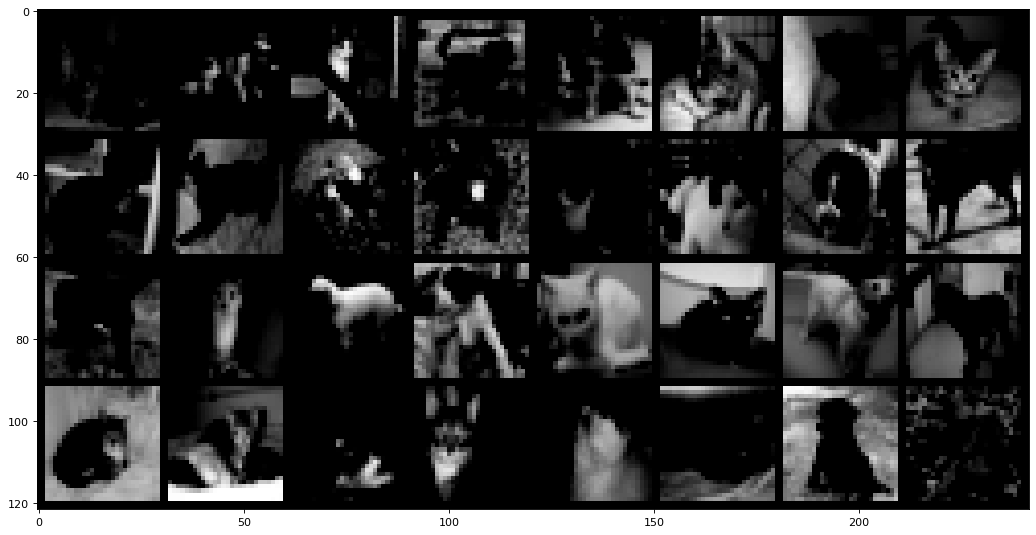

In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(num=None, figsize=(16, 14), dpi=80, facecolor='w', edgecolor='k')

def imshow(img):
  np_img = img.numpy()
  plt.imshow(np.transpose(np_img, (1, 2, 0)))

# Obtener imagenes
data_iter = iter(train_loader)
images, labels = data_iter.next()

# Mostrar imagenes
imshow(torchvision.utils.make_grid(images))

#2. Clasificador lineal multiclase

Desarrollo de los experimentos para un clasificador lineal multiclase utilizando la base de datos de imágenes de perros y gatos vista en clases.


## 2.1 Diseño del modelo propuesto

Explicar arquitectura clasificador multiclase:
* Entrada de datos
* Modelo lineal propuesto
* Salida esperada de datos

## 2.2 Parámetros y configuración del modelo

Explicar los parámetros e hiperparámetros seleccionados para la implementación del modelo, función de pérdida y modelo de optimización.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Implementar modelo (Imágenes de 28x28 y clasificación de dos clases)

linear_model = nn.Linear(784, 2)
#weight, bias = list(linear_model.parameters())
#print(weight.shape)
#print(bias.shape)

# Configurar hiperparámetros
learning_rate = 0.01
weight_decay = 0
num_epochs = 10

# Configurar función de pérdida
criterion = nn.CrossEntropyLoss()

# Configurar modelo de optimización
optimizer = optim.SGD(linear_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

## 3.3 Entrenamiento

Implementar entrenamiento.

In [ ]:
def get_accuracy(model, data):
  loader = torch.utils.data.DataLoader(data, batch_size=500)
  correct, total = 0, 0
  for xs, ts in loader:
    xs = xs.view(-1, 784) # Convertir la imagen en un vector
    zs = model(xs)
    pred = zs.max(1, keepdim=True)[1] # Obtener el índice de la clasificiación (logit)
    correct += pred.eq(ts.view_as(pred)).sum().item()
    total += int(ts.shape[0])
  return correct / total

In [ ]:
losses = []
iters_sub, train_acc, val_acc = [], [] ,[]

for epoch in range(num_epochs):
  losses_it = []
  for xs, ts in iter(train_loader):
    if len(ts) != batch_size:
      continue
    xs = xs.view(-1, 784) # Convertir la imagen en un vector
    zs = linear_model(xs) # Calcular la prediccion
    loss = criterion(zs, ts) # Calcular el loss total
    loss.backward() # Calcular gradientes
    optimizer.step() # Actualizar parámetros
    optimizer.zero_grad() # Borrar todos los cálculos anteriores en Pytorch
    losses_it.append(float(loss)/batch_size)

  # Guardar la información de entrenamiento de cada ciclo
  print(f'Epoch: {epoch}... ', end='')
  losses.append(sum(losses_it)/len(losses_it)) # Calcular el loss promedio
  iters_sub.append(epoch + 1)
  train_acc.append(get_accuracy(linear_model, gatos_perros_train))
  val_acc.append(get_accuracy(linear_model, gatos_perros_valid))


Epoch: 0... Epoch: 1... Epoch: 2... Epoch: 3... Epoch: 4... Epoch: 5... Epoch: 6... Epoch: 7... Epoch: 8... Epoch: 9... 

### Gráfico de función de pérdida del conjunto de entrenamiento y validación

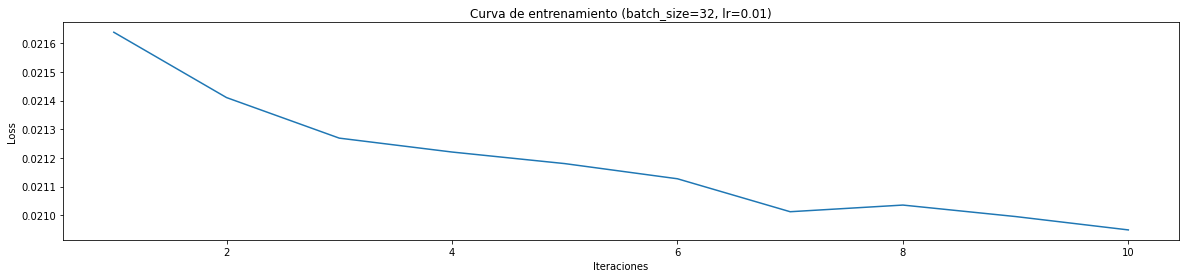

In [ ]:
# plotting
plt.figure(figsize=(20, 4))
plt.title("Curva de entrenamiento (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iters_sub, losses, label="Entrenamiento")
plt.xlabel("Iteraciones")
plt.ylabel("Loss")
plt.show()

### Gráfico de tasa de acierto del conjunto de entrenamiento y validación

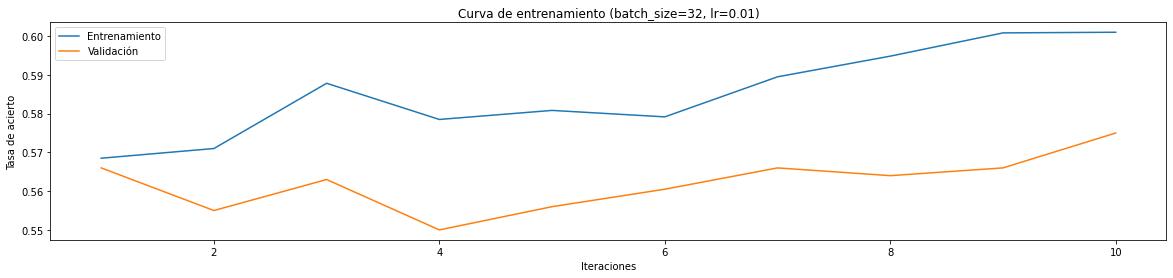

In [ ]:
plt.figure(figsize=(20, 4))
plt.title("Curva de entrenamiento (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iters_sub, train_acc, label="Entrenamiento")
plt.plot(iters_sub, val_acc, label="Validación")
plt.xlabel("Iteraciones")
plt.ylabel("Tasa de acierto")
plt.legend(loc='best')
plt.show()

### Visualizar la matriz de pesos resultante
Mostrar una imagen con las matrices resultantes para el problema multiclase.

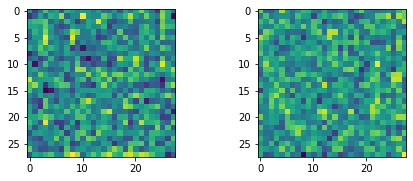

In [ ]:
#print(list(model.parameters()))

#for name, param in model.named_parameters():
#    print(name)
#    print(param)
#    print('-'*20)

# Obtengo los parámetros en formato diccionario
d = dict(linear_model.named_parameters())
# Selecciono solo los parámetros que ajunta la regresión lineal
w = d['weight']

import matplotlib.pyplot as plt


f = plt.figure(figsize=(20,6))
# Por cada vector de parámetros pesos grafico (10x728)
for index, template in enumerate(w):
  template = template.detach().numpy().reshape(28,28)
  plt.subplot(2, 5, index+1)
  plt.imshow(template)

## 2.3 Pruebas

Explicar como se realizarán los experimentos y su pruebas. 

Los experimentos del conjunto de pruebas dependen de los hiperparámetros obtenidos en el entrenamiento. Explicar como son fijados esos hiperparámetros para el conjunto de prueba.

## 2.4 Resultados

Mostrar los resultados del **entrenamiento** y **pruebas**. 
Utilizar métricas para mostrar bondad del modelo.(Matríz de confusión)
Utilizar gráficos. Explicar los resultados obtenidos.

### Matriz de confusión

Debe construir una para entrenamiento y otra para pruebas

|            	| Perro Pred. 	| Gato Pred. 	 |
|------------	|:-------------:|:------------:|
| Perro Real 	|      00     	|     00     	 |
| Gato Real  	|      00     	|     00     	 |

### Métricas

Debe construir una para entrenamiento y otra para pruebas

|           	| Clase Perro 	| Clase Gato 	 |
|-----------	|:-------------:|:------------:|
| Precisión 	|    00.00%  	  |    00.00%  	 |
| Recall    	|    00.00%    	|    00.00%  	 |

| Tasa de Acierto Global 	| 00.00% 	|
|------------------------	|:------:	|

#3. Clasificador red neuronal profunda convolucional

Desarrollo de los experimentos para un clasificador basado en redes neuronales profundas. Se utiliza una arquitectura de redes neuronales convolucionales.


## 3.1 Diseño del modelo propuesto

Explicar arquitectura neuronal:
* Entrada de datos
* Modelo de red neural propuesto
* Salida esperada de datos

## 3.2 Parámetros y configuración del modelo

Explicar los parámetros e hiperparámetros seleccionados para la implementación del modelo, función de pérdida y modelo de optimización.

In [20]:
# Implementar modelo
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module): 
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=512, kernel_size=3)
        self.conv2 = nn.Conv2d(512, 1024, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(25*1024, 1024) # Calculo (ultimo tamaño filtrado es de 5x5 y son 20 filtros)
        self.fc2 = nn.Linear(1024, 2)

    def forward(self, x): # Calcular la predicción
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

# Configurar hiperparámetros
num_epochs = 35
num_classes = 2
batch_size = 32
learning_rate = 0.01
weight_decay = 0.01

# CPU o GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# Declarar el modelo
model = CNN().to(device)

# Inicializar los pesos de la red
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        #torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.kaiming_normal_(m.weight)
        torch.nn.init.ones_(m.bias)

model.apply(weights_init)

# Configurar función de pérdida
criterion = nn.CrossEntropyLoss()

# Configurar modelo de optimización
optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate, weight_decay=weight_decay)

cuda:0


## 3.3 Entrenamiento

Implementar entrenamiento.


In [21]:
# Implementar entrenamiento
#%%timeit

# Listas para mantener el seguimiento de la pérdida del conjunto de entrenamiento
# y el conjunto de validación
train_losses = []
valid_losses = []

for epoch in range(1, num_epochs + 1):
    # Para cada epoch acumular el valor de la función de pérdida
    train_loss = 0.0
    valid_loss = 0.0
    
    # Paso: Entrenamiento del modelo
    model.train()
    for data, target in train_loader:
        # Mover los tensores de los datos y etiquetas a la GPU o CPU
        data = data.to(device)
        target = target.to(device)
        
        # Dejar los gradientes en cero
        optimizer.zero_grad()
        # forward(): Calcular la predicción de etiquetas desde el modelo
        output = model(data)
        # Calcular la pérdida (error) entre las etiquetas reales y la predicción
        loss = criterion(output, target)
        # Calcular los gradientes a partir del error
        loss.backward()
        # Actualizar los pesos mediante una función de optimización
        optimizer.step()
        # Actualizar la función de pérdida por batch
        train_loss += loss.item() * data.size(0)
        
    # Una vez ENTRENADO el modelo
    # Calcular las predicciones del conjunto de validación
    model.eval()
    for data, target in valid_loader:
        
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        
        loss = criterion(output, target)
        
        # Actualizar la función de pérdida por batch
        valid_loss += loss.item() * data.size(0)
    
    # Calcular las pérdidas de cada epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

Epoch: 1 	Training Loss: 1.430566 	Validation Loss: 0.669570
Epoch: 2 	Training Loss: 0.667707 	Validation Loss: 0.656057
Epoch: 3 	Training Loss: 0.660445 	Validation Loss: 0.668231
Epoch: 4 	Training Loss: 0.643859 	Validation Loss: 0.655118
Epoch: 5 	Training Loss: 0.643404 	Validation Loss: 0.638738
Epoch: 6 	Training Loss: 0.631979 	Validation Loss: 0.669920
Epoch: 7 	Training Loss: 0.626568 	Validation Loss: 0.630365
Epoch: 8 	Training Loss: 0.620141 	Validation Loss: 0.626096
Epoch: 9 	Training Loss: 0.618742 	Validation Loss: 0.633053
Epoch: 10 	Training Loss: 0.611909 	Validation Loss: 0.611805
Epoch: 11 	Training Loss: 0.601859 	Validation Loss: 0.627882
Epoch: 12 	Training Loss: 0.599076 	Validation Loss: 0.598296
Epoch: 13 	Training Loss: 0.596520 	Validation Loss: 0.661837
Epoch: 14 	Training Loss: 0.589021 	Validation Loss: 0.624164
Epoch: 15 	Training Loss: 0.581232 	Validation Loss: 0.597474
Epoch: 16 	Training Loss: 0.578252 	Validation Loss: 0.590264
Epoch: 17 	Traini

In [24]:
# PERSISTENCIA 01: Guardar solo los pesos y crear la estructura la red desde cero 
# para luego cargarla con los pesos guardados. (RECOMENDADO)

# Guardar solo los pesos (w) modelo (Recomienda)
torch.save(model.state_dict(), '/content/model-pesos.pickle')

model = CNN().to(device)
model.load_state_dict(torch.load('/content/model-pesos.pickle'))

# Validación o pruebas
model.eval()

CNN(
  (conv1): Conv2d(1, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=25600, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)

In [11]:
# Persistencia 02: Guardar el modelo completo.

# Guardar el modelo (estructura de datos) y los pesos (w)
torch.save(model, '/content/model-pesos-ed.pickle')

# Cargar el modelo completo, no es necesario crearlo
model_all = torch.load('/content/model-pesos-ed.pickle')
model_all.eval()

CNN(
  (conv1): Conv2d(1, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=25600, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)

In [25]:
# test-the-model
model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

Test Accuracy of the model: 70.7 %


### Gráfico de función de pérdida del conjunto de entrenamiento y validación

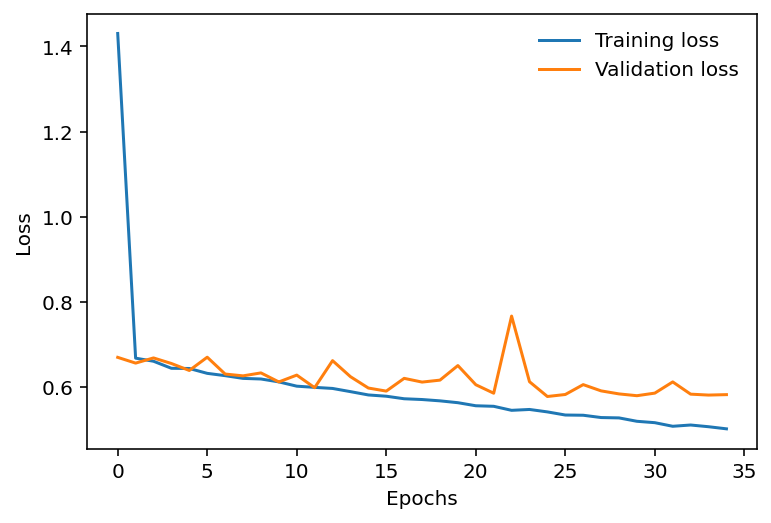

In [26]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

### Gráfico de tasa de acierto del conjunto de entrenamiento y validación

### Visualizar los mapas de activación

Mostrar los mapas de activación para un ejemplo de perro y otro para el ejemplo de gato.

In [ ]:
# Codigo...

## 3.4 Pruebas

Explicar como se realizarán los experimentos y su pruebas. 

Los experimentos del conjunto de pruebas dependen de los hiperparámetros obtenidos en el entrenamiento. Explicar como son fijados esos hiperparámetros para el conjunto de prueba.

In [ ]:
def custom_viz(kernels, path=None, cols=None, size=None, verbose=False, axis=False):
    """Visualize weight and activation matrices learned 
    during the optimization process. Works for any size of kernels.
    
    Arguments
    =========
    kernels: Weight or activation matrix. Must be a high dimensional
    Numpy array. Tensors will not work.
    path: Path to save the visualizations.
    cols: Number of columns (doesn't work completely yet.)
    size: Tuple input for size. For example: size=(5,5)
    verbose: Print information about the input.
    Example
    =======
    kernels = model.conv1.weight.cpu().detach().clone()
    kernels = kernels - kernels.min()
    kernels = kernels / kernels.max()
    custom_viz(kernels, 'results/conv1_weights.png', 5)
    """
    def set_size(w,h, ax=None):
        """ w, h: width, height in inches """
        if not ax: ax=plt.gca()
        l = ax.figure.subplotpars.left
        r = ax.figure.subplotpars.right
        t = ax.figure.subplotpars.top
        b = ax.figure.subplotpars.bottom
        figw = float(w)/(r-l)
        figh = float(h)/(t-b)
        ax.figure.set_size_inches(figw, figh)
    
    N = kernels.shape[0]
    C = kernels.shape[1]
    total_cols = N*C
    pos = range(1,total_cols + 1)
    
    if verbose:
        print("Shape of input: ", kernels.shape)
        
    if cols==None:
        req_cols = C
        num_rows = N
    elif cols:
        req_cols = cols
        # Account for more rows while diving total cols
        # with requested number of cols in the figure
        # Hence, using np.ceil to get the largest int
        # from the quotient of division.
        num_rows = int(np.ceil(total_cols/req_cols))
    elif C>1:
        # Check for 1D arrays and such. Mostly not needed.
        req_cols = C

    fig = plt.figure(1)
    fig.tight_layout()
    k=0
    for i in range(kernels.shape[0]):
        for j in range(kernels.shape[1]):
            img = kernels[i][j]
            ax = fig.add_subplot(num_rows,req_cols,pos[k])
            ax.imshow(img, cmap='gray')
            if axis:
                plt.axis('on')
            elif axis==False:
                plt.axis('off')
            k = k+1
    if size:
        size_h,size_w = size
        set_size(size_h,size_w,ax)
    if path:
        plt.savefig(path, dpi=100)
    plt.show()

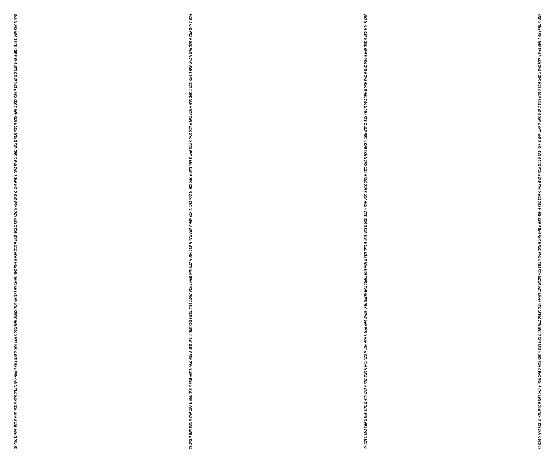

In [ ]:
kernels = model.conv1.weight.cpu().detach().clone()
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
custom_viz(kernels, '/content/conv1_weights.png', 4)

torch.Size([512, 1, 3, 3])


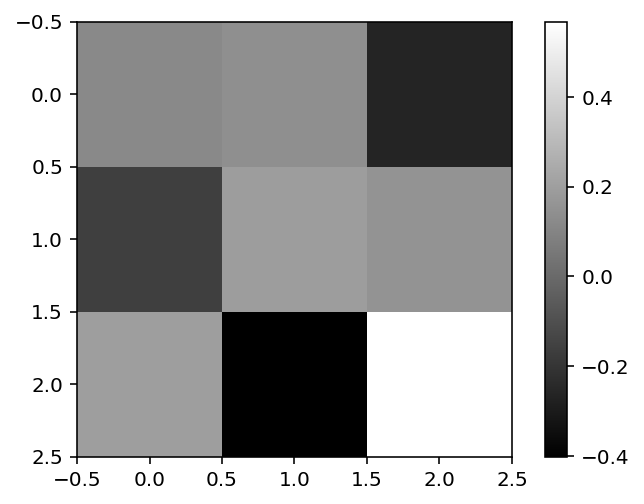

In [41]:
# Dibujar el primer kernel
kernels = model.conv1.weight.cpu().detach().clone()
print(kernels.shape)

# Imprimir primer kernel
plt.imshow(kernels[0][0], cmap='gray')
plt.colorbar()


0 torch.Size([32, 1, 28, 28]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([1, 1, 28, 28])
torch.Size([1, 512, 26, 26])


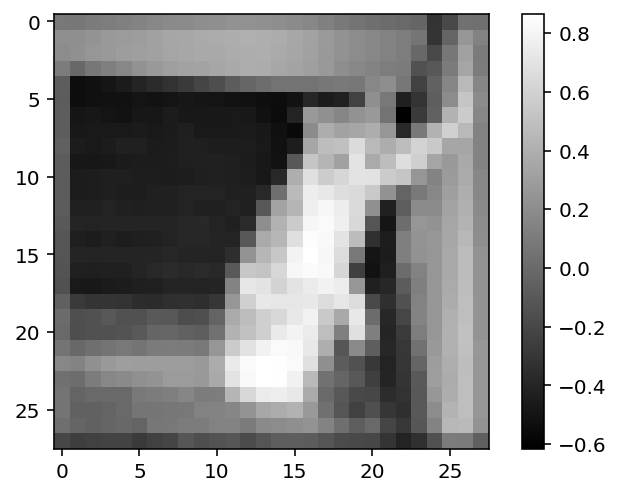

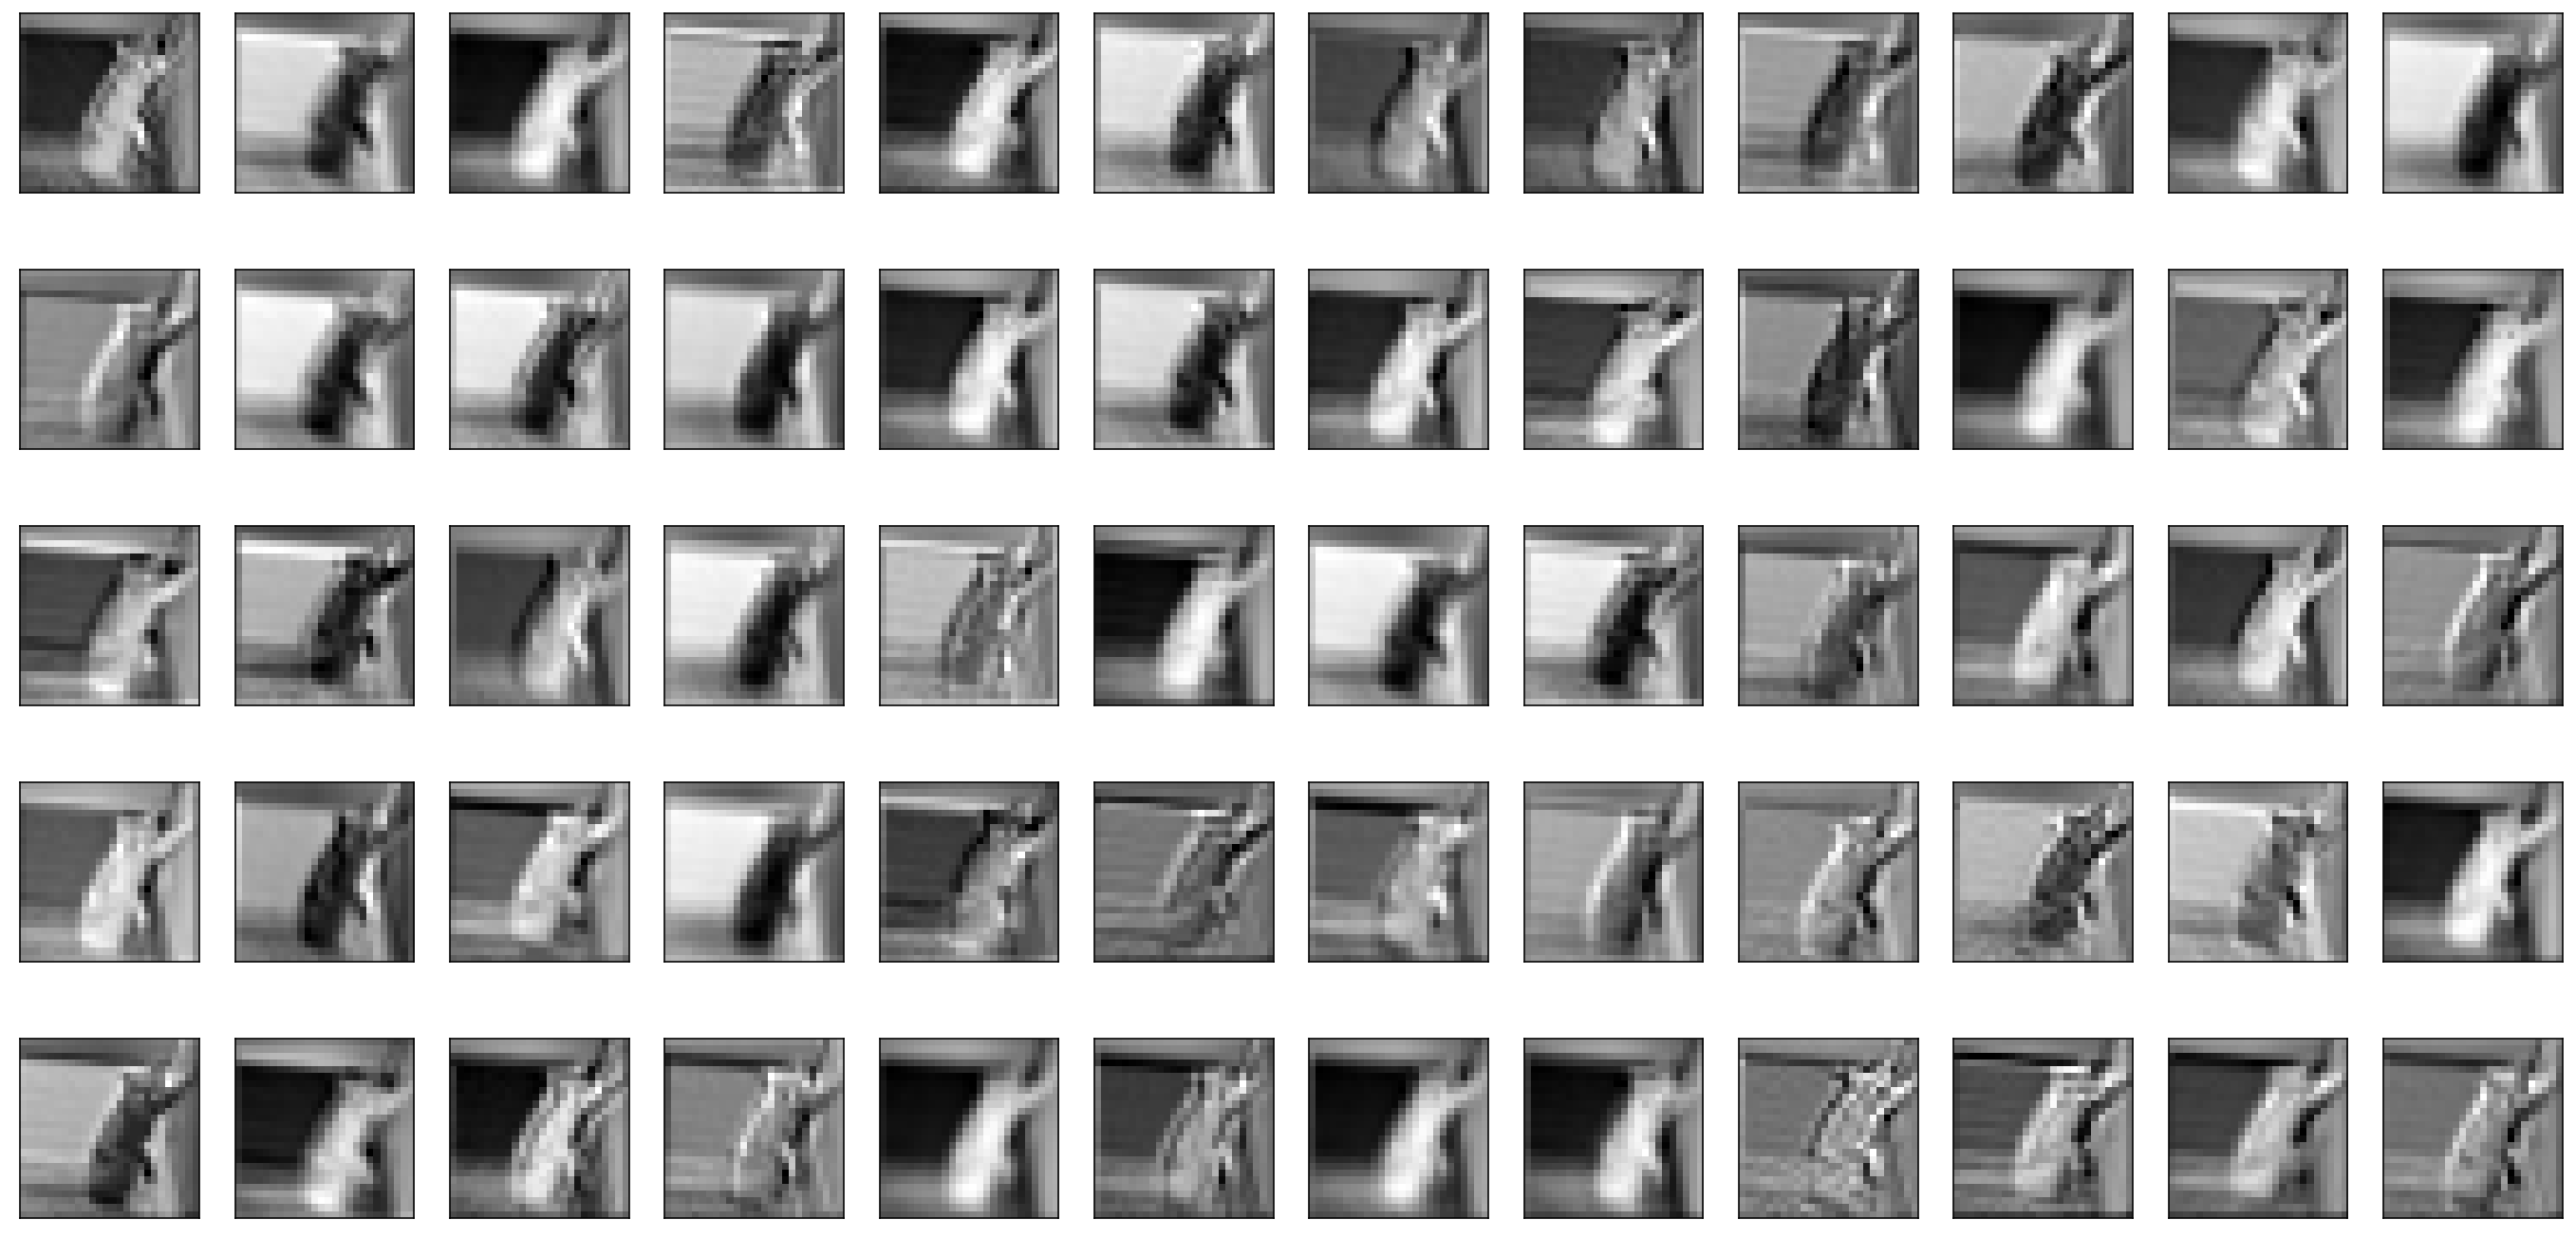

In [83]:
from torch.autograd import Variable

# Ver imágenes filtradas en la primera capa convulocional
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(batch_idx, example_data.shape, example_targets)

# Obtenemos la primera imagen del conjunto de entrenamiento
# Un gato
cat = example_data[0]
print(number.shape)

# Mostramos la imagen del gato
plt.imshow(cat[0], cmap='gray')
plt.colorbar()

# Congelamos los datos de la imagen
cat.unsqueeze_(0)
cat = Variable(number, requires_grad=False)

# Aplicamos todos los filtros de la primera capa convulocional a la imagen
conv1_out = model.conv1.forward(cat.cuda())
print(conv1_out.shape)

# Creo una copia de todas las imágenes filtradas fuera de la GPU
conv1_out_cpu = conv1_out.cpu().detach().clone()

# Mostramos las primeras 60 imágenes filtradas
fig, axs = plt.subplots(nrows=5, ncols=12, figsize=(24, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for index, ax in enumerate(axs.flat):  
   ax.imshow(conv1_out_cpu[0][index], cmap='gray')


## 3.5 Resultados

Mostrar los resultados del entrenamiento y pruebas. 
Utilizar métricas para mostrar bondad del modelo.(Matríz de confusión)
Utilizar gráficos. Explicar los resultados obtenidos.

Debe construir una para entrenamiento y otra para pruebas

|            	| Perro Pred. 	| Gato Pred. 	 |
|------------	|:-------------:|:------------:|
| Perro Real 	|      00     	|     00     	 |
| Gato Real  	|      00     	|     00     	 |

### Métricas

Debe construir una para entrenamiento y otra para pruebas

|           	| Clase Perro 	| Clase Gato 	 |
|-----------	|:-------------:|:------------:|
| Precisión 	|    00.00%  	  |    00.00%  	 |
| Recall    	|    00.00%    	|    00.00%  	 |

| Tasa de Acierto Global 	| 00.00% 	|
|------------------------	|:------:	|




#4. Conclusiones

Conclusiones sobre el uso de la técnica. Ventajas y desventajas. ¿Se cumplen los objetivos del laboratorio?. ¿Como se comparan los resultados con los experimientos hechos en clases para el mismo problema?

